<h1><center>Home Credit Risk Prediction</center></h1>
<center>December 2024</center>
<center>Celine Ng</center>

# Table of Contents

1. Project Introduction   
    1. Notebook Preparation
    1. Data loading
1. Main Data Preparation
    1. Data cleaning
    1. Dataframes and keys
    1. Train Test Split
    1. Quick EDA
        1. Keys present in each table
        1. Distribution
    1. Aggregation
1. Initial Data Cleaning
    1. Duplicate rows
    1. Datatypes
    1. Missing values
    1. Values
1. EDA
    1. Correlation
    1. Statistical Inference
    1. Distribution
1. Data Preprocessing
1. Feature Selection
    1. All features included
    1. Mutual Information
    1. PCA
1. Models
    1. Baseline model
    1. Basic model
    1. Hyperparameter Tuning
    1. Test Data
    1. Final Model
    1. Deployment
    1. Model Interpretation
1. Improvements

# 1. Project Introduction

**Crucial problem for retail banks** <br>
1. Minimize loan defaults by evaluating credit risk accurately.
2. Maximize profits by better identifying customers that are NOT 
currently handed out loans but are potentially reliable.


**Project Objective**<br>
The second problem is not solvable with provided data. So the focus of this 
project would be the following:<br>
1. Improve risk evaluation accuracy to retail banks. In practice
 meaning target variable classification.
2. Evaluate feature importance to explain decisions.
3. Provide actionable insights to improve credit scoring.

**Initial Plan**<br>
1. Data cleaning (missing values counting) of each table
2. Select important tables
3. Aggregate table information - 1 row per person instead of loan
4. Join columns to main table
5. EDA and statistical inference
6. Feature engineering - New feature creations with domain knowledge
7. Feature selection
8. Modeling 
9. Hyperparameter tuning
10. Evaluation with cross validation
11. Deployment
12. Model interpretation

## 1.1. Notebook Preparation

In [1]:
%%capture
%pip install -r requirements.txt

In [2]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import pickle

import os
from utils.eda import *
from utils.data_preparation import *
from utils.custom_preprocessor import *
from utils.get_data_merged_train import *

from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import train_test_split

## 1.2. Data Loading

Objective: Brief overview of our datasets, including the features and target 
variable

The data comes with 10 separate CSV files. It is originally based on a Kaggle
 competition that is now closed, 
[Home Credit Default Risk](https://www.kaggle.com/competitions/home-credit-default-risk/overview).

<ol>
<li>application_{train|test}.csv

This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
Static data for all applications. One row represents one loan in our data 
sample.</li>
<li>bureau.csv

All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
For every loan in our sample, there are as many rows as number of credits 
the client had in Credit Bureau before the application date.</li>
<li>bureau_balance.csv

Monthly balances of previous credits in Credit Bureau.
This table has one row for each month of history of every previous credit 
reported to Credit Bureau – i.e the table has (#loans in sample * # of 
relative previous credits * # of months where we have some history 
observable for the previous credits) rows.</li>
<li>POS_CASH_balance.csv

Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
This table has one row for each month of history of every previous credit in
 Home Credit (consumer credit and cash loans) related to loans in our sample
  – i.e. the table has (#loans in sample * # of relative previous credits 
  *# of months in which we have some history observable for the previous 
  credits) rows.</li>
<li>credit_card_balance.csv

Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
This table has one row for each month of history of every previous credit in
 Home Credit (consumer credit and cash loans) related to loans in our sample
  – i.e. the table has (#loans in sample * # of relative previous credit 
  cards *# of months where we have some history observable for the previous
   credit card) rows.</li>
<li>previous_application.csv

All previous applications for Home Credit loans of clients who have loans in our sample.
There is one row for each previous application related to loans in our data 
sample.</li>
<li>installments_payments.csv

Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
There is a) one row for every payment that was made plus b) one row each for missed payment.
One row is equivalent to one payment of one installment OR one installment 
corresponding to one payment of one previous Home Credit credit related to 
loans in our sample.</li>

**Adjacent csv files:**
<li>HomeCredit_columns_description.csv

This file contains descriptions for the columns in the various data files.</li>

<li>sample submission.csv
Sample submission file for Kaggle competition</li>
</ol>

*Non-adjacent csv files will be converted into pkl files for more efficient 
memory usage. To do so, please run 'convert_csv_to_pkl.py'.*

**Home Credit columns description**

In [3]:
description = pd.read_csv('../data_csv/HomeCredit_columns_description.csv', encoding='latin1')
display(description.head())
description_shape = description.shape
print(f"Number of rows on bureau data_csv: {description_shape[0]}\nNumber of "
      f"columns on bureau data_csv: {description_shape[1]}")

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN


Number of rows on bureau data_csv: 219
Number of columns on bureau data_csv: 5


In [4]:
description.iloc[1, 3]

'Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)'

In [5]:
description.loc[description['Row'] == 'SK_ID_CURR', 'Description']

0                               ID of loan in our sample
122    ID of loan in our sample - one loan in our sam...
143                             ID of loan in our sample
151                             ID of loan in our sample
174                             ID of loan in our sample
212                             ID of loan in our sample
Name: Description, dtype: object

**Application train**

In [6]:
application_train = pd.read_pickle('../data_pkl/application_train.pkl')
display(application_train.head())
application_train_shape = application_train.shape
print(f"Number of rows on train data_csv: {application_train_shape[0]}\nNumber of "
      f"columns on train data_csv: {application_train_shape[1]}")

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


Number of rows on train data_csv: 307511
Number of columns on train data_csv: 122


**Application Test**

In [7]:
application_test = pd.read_pickle('../data_pkl/application_test.pkl')
display(application_test.head())
application_test_shape = application_test.shape
print(f"Number of rows on train data_csv: {application_test_shape[0]}\nNumber of "
      f"columns on train data_csv: {application_test_shape[1]}")

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


Number of rows on train data_csv: 48744
Number of columns on train data_csv: 121


For both application train and test, SK_ID_CURR is the key that identifies 
each row in the table.

**Bureau**

In [8]:
bureau = pd.read_pickle('../data_pkl/bureau.pkl')
display(bureau.head())
bureau_shape = bureau.shape
print(f"Number of rows on bureau data_csv: {bureau_shape[0]}\nNumber of "
      f"columns on bureau data_csv: {bureau_shape[1]}")

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


Number of rows on bureau data_csv: 1716428
Number of columns on bureau data_csv: 17


**Bureau Balance**

In [9]:
bureau_balance = pd.read_pickle('../data_pkl/bureau_balance.pkl')
display(bureau_balance.head())
bureau_balance_shape = bureau_balance.shape
print(f"Number of rows on bureau data_csv: {bureau_balance_shape[0]}\nNumber of "
      f"columns on bureau data_csv: {bureau_balance_shape[1]}")

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


Number of rows on bureau data_csv: 27299925
Number of columns on bureau data_csv: 3


**Previous Application**

In [10]:
previous_application = pd.read_pickle('../data_pkl/previous_application.pkl')
display(previous_application.head())
previous_application_shape = previous_application.shape
print(f"Number of rows on bureau data_csv: {previous_application_shape[0]}\nNumber of "
      f"columns on bureau data_csv: {previous_application_shape[1]}")

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


Number of rows on bureau data_csv: 1670214
Number of columns on bureau data_csv: 37


**POS CASH balance**

In [11]:
POS_CASH_balance = pd.read_pickle('../data_pkl/POS_CASH_balance.pkl')
display(POS_CASH_balance.head())
POS_CASH_balance_shape = POS_CASH_balance.shape
print(f"Number of rows on bureau data_csv: {POS_CASH_balance_shape[0]}\nNumber of "
      f"columns on bureau data_csv: {POS_CASH_balance_shape[1]}")

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


Number of rows on bureau data_csv: 10001358
Number of columns on bureau data_csv: 8


**Installments Payments**

In [12]:
installments_payments = pd.read_pickle('../data_pkl/installments_payments.pkl')
display(installments_payments.head())
installments_payments_shape = installments_payments.shape
print(f"Number of rows on bureau data_csv: {installments_payments_shape[0]}\nNumber of "
      f"columns on bureau data_csv: {installments_payments_shape[1]}")

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


Number of rows on bureau data_csv: 13605401
Number of columns on bureau data_csv: 8


**Credit Card Balance**

In [13]:
credit_card_balance = pd.read_pickle('../data_pkl/credit_card_balance.pkl')
display(credit_card_balance.head())
credit_card_balance_shape = credit_card_balance.shape
print(f"Number of rows on bureau data_csv: {credit_card_balance_shape[0]}\nNumber of"
      f"columns on bureau data_csv: {credit_card_balance_shape[1]}")

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


Number of rows on bureau data_csv: 3840312
Number ofcolumns on bureau data_csv: 23


# 2. Main Data Preparation
Objective:
In order to aggregate data to main data tables, a quick exploration is 
needed to understand which data are useful and how should each be aggregated
. These data will also need to be split into train and test before the 
aggregation, as the main table is already split.

## 2.1. Data Cleaning
Objective: Initial brief data cleaning to check what data is usable for 
further analysis.

**Duplicates**

In [14]:
application_test.duplicated().any()

np.False_

In [15]:
application_train.duplicated().any()

np.False_

In [16]:
sk_id_curr_train = application_train['SK_ID_CURR']
sk_id_curr_test = application_test['SK_ID_CURR']

duplicate_ids = set(sk_id_curr_train).intersection(set(sk_id_curr_test))
duplicate_ids

set()

No duplicates, so each table has unique loan ID, SK_ID_CURR. Meaning 
SK_ID_CURR from application tables will help distinguish loans for training 
and loans for test.

**Check for Missing Values** -<br>
There is a possibility of abandoning certain tables if they contained too many 
missing values.

In [17]:
dataframes = {
      'application_train': application_train, 
      'application_test': application_test, 
      'bureau': bureau,
      'bureau_balance': bureau_balance,
      'credit_card_balance': credit_card_balance, 
      'installments_payments': installments_payments,
      'POS_CASH_balance': POS_CASH_balance, 
      'previous_application': previous_application
}

for df_name, df in dataframes.items():
      print(df_name)
      display(missing_values(df).sort_values(ascending=False, by='Missing '
                                                                 'Values'))

application_train


,Missing Values,Percentage Missing,Datatype
COMMONAREA_MEDI,214865,69.87,float64
COMMONAREA_AVG,214865,69.87,float64
COMMONAREA_MODE,214865,69.87,float64
NONLIVINGAPARTMENTS_MODE,213514,69.43,float64
NONLIVINGAPARTMENTS_AVG,213514,69.43,float64
...,...,...,...
NAME_HOUSING_TYPE,0,0.00,object
NAME_FAMILY_STATUS,0,0.00,object
NAME_EDUCATION_TYPE,0,0.00,object
NAME_INCOME_TYPE,0,0.00,object


application_test


,Missing Values,Percentage Missing,Datatype
COMMONAREA_AVG,33495,68.72,float64
COMMONAREA_MODE,33495,68.72,float64
COMMONAREA_MEDI,33495,68.72,float64
NONLIVINGAPARTMENTS_AVG,33347,68.41,float64
NONLIVINGAPARTMENTS_MODE,33347,68.41,float64
...,...,...,...
NAME_HOUSING_TYPE,0,0.00,object
NAME_FAMILY_STATUS,0,0.00,object
NAME_EDUCATION_TYPE,0,0.00,object
NAME_INCOME_TYPE,0,0.00,object


bureau


,Missing Values,Percentage Missing,Datatype
AMT_ANNUITY,1226791,71.47,float64
AMT_CREDIT_MAX_OVERDUE,1124488,65.51,float64
DAYS_ENDDATE_FACT,633653,36.92,float64
AMT_CREDIT_SUM_LIMIT,591780,34.48,float64
AMT_CREDIT_SUM_DEBT,257669,15.01,float64
DAYS_CREDIT_ENDDATE,105553,6.15,float64
AMT_CREDIT_SUM,13,0.00,float64
CREDIT_ACTIVE,0,0.00,object
CREDIT_CURRENCY,0,0.00,object
DAYS_CREDIT,0,0.00,int64


bureau_balance


,Missing Values,Percentage Missing,Datatype
SK_ID_BUREAU,0,0.0,int64
MONTHS_BALANCE,0,0.0,int64
STATUS,0,0.0,object


credit_card_balance


,Missing Values,Percentage Missing,Datatype
AMT_PAYMENT_CURRENT,767988,20.00,float64
AMT_DRAWINGS_ATM_CURRENT,749816,19.52,float64
CNT_DRAWINGS_POS_CURRENT,749816,19.52,float64
AMT_DRAWINGS_OTHER_CURRENT,749816,19.52,float64
AMT_DRAWINGS_POS_CURRENT,749816,19.52,float64
CNT_DRAWINGS_OTHER_CURRENT,749816,19.52,float64
CNT_DRAWINGS_ATM_CURRENT,749816,19.52,float64
CNT_INSTALMENT_MATURE_CUM,305236,7.95,float64
AMT_INST_MIN_REGULARITY,305236,7.95,float64
SK_ID_PREV,0,0.00,int64


installments_payments


,Missing Values,Percentage Missing,Datatype
DAYS_ENTRY_PAYMENT,2905,0.02,float64
AMT_PAYMENT,2905,0.02,float64
SK_ID_PREV,0,0.00,int64
SK_ID_CURR,0,0.00,int64
NUM_INSTALMENT_VERSION,0,0.00,float64
NUM_INSTALMENT_NUMBER,0,0.00,int64
DAYS_INSTALMENT,0,0.00,float64
AMT_INSTALMENT,0,0.00,float64


POS_CASH_balance


,Missing Values,Percentage Missing,Datatype
CNT_INSTALMENT_FUTURE,26087,0.26,float64
CNT_INSTALMENT,26071,0.26,float64
SK_ID_PREV,0,0.00,int64
SK_ID_CURR,0,0.00,int64
MONTHS_BALANCE,0,0.00,int64
NAME_CONTRACT_STATUS,0,0.00,object
SK_DPD,0,0.00,int64
SK_DPD_DEF,0,0.00,int64


previous_application


,Missing Values,Percentage Missing,Datatype
RATE_INTEREST_PRIVILEGED,1664263,99.64,float64
RATE_INTEREST_PRIMARY,1664263,99.64,float64
AMT_DOWN_PAYMENT,895844,53.64,float64
RATE_DOWN_PAYMENT,895844,53.64,float64
NAME_TYPE_SUITE,820405,49.12,object
NFLAG_INSURED_ON_APPROVAL,673065,40.30,float64
DAYS_TERMINATION,673065,40.30,float64
DAYS_LAST_DUE,673065,40.30,float64
DAYS_LAST_DUE_1ST_VERSION,673065,40.30,float64
DAYS_FIRST_DUE,673065,40.30,float64


There are some features with large amount of missing values. However, no one
 table has too many missing values where it needs to be discarded as a whole
 .<br>
 For modeling, tree based and non tree based models like logistic 
 regression, naive bayes, random forest, XGBoost, and LightGBM will be 
 tested. Non tree based models require complete data, while imputation and 
 feature removal will still be considered when >40% of missing data for tree 
 based models.

## 2.2. Dataframes and Keys

In [18]:
keys_to_check = ['SK_ID_CURR', 'SK_ID_PREV', 'SK_ID_BUREAU']
results = []

for table_name, df in dataframes.items():
    row = {'Table': table_name, 'Total_Rows': len(df)}
    
    for key in keys_to_check:
        row[key] = df[key].nunique() if key in df.columns else None
    results.append(row)

key_counts_df = pd.DataFrame(results)
key_counts_df

,Table,Total_Rows,SK_ID_CURR,SK_ID_PREV,SK_ID_BUREAU
0,application_train,307511,307511.0,NaN,NaN
1,application_test,48744,48744.0,NaN,NaN
2,bureau,1716428,305811.0,NaN,1716428.0
3,bureau_balance,27299925,NaN,NaN,817395.0
4,credit_card_balance,3840312,103558.0,104307.0,NaN
5,installments_payments,13605401,339587.0,997752.0,NaN
6,POS_CASH_balance,10001358,337252.0,936325.0,NaN
7,previous_application,1670214,338857.0,1670214.0,NaN


Total SK_ID_CURR, loan IDs : 356255<br>
Total SK_ID_BUREAU, bureau loan IDs : 1716428, from 305811 loan IDs. 
About 14.16% of SK_ID_CURR do not have bureau info.<br>
Total SK_ID_PREV, previous loan IDs : 1670214, from 338857 loan IDs
. About 4.88% of SK_ID_CURR do not have previous loan info.<br><br>
    
**Tables with unique keys:**<br>
    1. application_train: SK_ID_CURR<br>
    2. application_test: SK_ID_CURR <br>
    3. bureau: SK_ID_BUREAU. <i>Each SK_ID_CURR can correspond to 
    several SK_ID_BUREAU, and not all SK_ID_CURR are present in this 
    dataframe.</i><br>
    4. previous_application: SK_ID_PREV. <i>Each SK_ID_CURR can correspond to 
    several SK_ID_PREV, and not all SK_ID_CURR are present in this 
    dataframe.</i><br><br>
    
**Tables without unique keys:**<br>
    1. bureau_balance: SK_ID_BUREAU corresponds to several rows. Not all 
    SK_ID_BUREAU are present in this dataframe.<br>
    2. credit_card_balance: SK_ID_PREV corresponds to several rows. Not all 
    SK_ID_PREV are present in this dataframe.<br>
    3. installments_payments: SK_ID_PREV corresponds to several rows. Not 
    all SK_ID_PREV are present in this dataframe.<br>
    4. POS_CASH_balance: SK_ID_PREV corresponds to several rows. Not all 
    SK_ID_PREV are present in this dataframe.<br><br>

## 2.3. Train Test Split
Objective: 
Data split into train/test to avoid data leakage. 

The tables will be first split before any analysis to minimize data 
leakage. <br>
*bureau_balance* does not have SK_ID_CURR, so it cannot be directly split into
 train/test by that key. However, rows are identified by SK_ID_BUREAU. This 
 method can also be used for *credit_card_balance*, *installments_payment*, 
 and *POS_CASH_balance*.<br>

**Split All Data into Train Test files -** All *test* files generated here are 
only used for kaggle submission

Split bureau by SK_ID_CURR

In [19]:
bureau_train = bureau[bureau['SK_ID_CURR'].isin(sk_id_curr_train)]
bureau_test = bureau[bureau['SK_ID_CURR'].isin(sk_id_curr_test)]
duplicate_curr = (set(bureau_train['SK_ID_CURR'])
                  .intersection(set(bureau_test['SK_ID_CURR'])))
duplicate_bur = (set(bureau_train['SK_ID_BUREAU'])
                 .intersection(set(bureau_test['SK_ID_BUREAU'])))
print(f"duplicated SK_ID_CURR in bureau "
      f"train test tables: {duplicate_curr}"
      f"\nduplicated SK_ID_BUREAU in bureau train test tables: "
      f"{duplicate_bur}")

duplicated SK_ID_CURR in bureau train test tables: set()
duplicated SK_ID_BUREAU in bureau train test tables: set()


Split bureau_balance by SK_ID_BUREAU

In [20]:
sk_id_bureau_train = bureau_train['SK_ID_BUREAU'].unique()
sk_id_bureau_test = bureau_test['SK_ID_BUREAU'].unique()

bureau_balance_train = bureau_balance[bureau_balance['SK_ID_BUREAU'].isin
(sk_id_bureau_train)]
bureau_balance_test = bureau_balance[bureau_balance['SK_ID_BUREAU'].isin
(sk_id_bureau_test)]

Split previous_application by SK_ID_CURR

In [21]:
previous_application_train =(
    previous_application)[previous_application[
    'SK_ID_CURR'].isin(sk_id_curr_train)]
previous_application_test = (
    previous_application)[previous_application[
    'SK_ID_CURR'].isin(sk_id_curr_test)]
duplicate_curr = set(previous_application_train['SK_ID_CURR']).intersection(set
                                                         (previous_application_test['SK_ID_CURR']))
duplicate_bur = set(previous_application_train['SK_ID_PREV']).intersection(set
                                                         (previous_application_test['SK_ID_PREV']))
print(f"duplicated SK_ID_CURR in previous_application  "
      f"train test tables: {duplicate_curr}"
      f"\nduplicated SK_ID_PREV in previous_application train test tables: "
      f"{duplicate_bur}")

duplicated SK_ID_CURR in previous_application  train test tables: set()
duplicated SK_ID_PREV in previous_application train test tables: set()


Split credit_card_balance, installments_payments, POS_CASH_balance by 
SK_ID_PREV

In [22]:
sk_id_prev_train = previous_application_train['SK_ID_PREV'].unique()
sk_id_prev_test = previous_application_test['SK_ID_PREV'].unique()

credit_card_balance_train = (
    credit_card_balance)[credit_card_balance[('SK_ID_PREV')].isin(
    sk_id_prev_train)]
credit_card_balance_test = (
    credit_card_balance)[credit_card_balance['SK_ID_PREV'].isin(
    sk_id_prev_test)]

installments_payments_train = (
    installments_payments)[installments_payments['SK_ID_PREV'].isin(
    sk_id_prev_train)]
installments_payments_test = (
    installments_payments)[installments_payments['SK_ID_PREV'].isin(
    sk_id_prev_test)]

POS_CASH_balance_train = (
    POS_CASH_balance)[POS_CASH_balance['SK_ID_PREV'].isin(sk_id_prev_train)]
POS_CASH_balance_test = (
    POS_CASH_balance)[POS_CASH_balance['SK_ID_PREV'].isin(sk_id_prev_test)]

Save all *test* dataframes as .pkl files in a new folder called 
**data_kaggle**, 
as these files will only be used for kaggle submission.

In [23]:
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

test_folder = os.path.join(project_root, "data_kaggle")
os.makedirs(test_folder, exist_ok=True)

data_pkl_folder = os.path.join(project_root, "data_pkl")
application_test_path = os.path.join(data_pkl_folder, "application_test.pkl")
application_test = pd.read_pickle(application_test_path)

test_dataframes = {
    'bureau_test': bureau_test,
    'bureau_balance_test': bureau_balance_test,
    'previous_application_test': previous_application_test,
    'credit_card_balance_test': credit_card_balance_test,
    'installments_payments_test': installments_payments_test,
    'POS_CASH_balance_test': POS_CASH_balance_test, 
    'application_test': application_test
}

for name, df in test_dataframes.items():
    file_path = os.path.join(test_folder, f"{name}.pkl")
    df.to_pickle(file_path)
    print(f"Saved {name} to {file_path}")

print("\nAll test DataFrames have been saved.")

Saved bureau_test to /Users/celineng/PycharmProjects/chilng-DS.v2.5.3.4.1/data_kaggle/bureau_test.pkl
Saved bureau_balance_test to /Users/celineng/PycharmProjects/chilng-DS.v2.5.3.4.1/data_kaggle/bureau_balance_test.pkl
Saved previous_application_test to /Users/celineng/PycharmProjects/chilng-DS.v2.5.3.4.1/data_kaggle/previous_application_test.pkl
Saved credit_card_balance_test to /Users/celineng/PycharmProjects/chilng-DS.v2.5.3.4.1/data_kaggle/credit_card_balance_test.pkl
Saved installments_payments_test to /Users/celineng/PycharmProjects/chilng-DS.v2.5.3.4.1/data_kaggle/installments_payments_test.pkl
Saved POS_CASH_balance_test to /Users/celineng/PycharmProjects/chilng-DS.v2.5.3.4.1/data_kaggle/POS_CASH_balance_test.pkl
Saved application_test to /Users/celineng/PycharmProjects/chilng-DS.v2.5.3.4.1/data_kaggle/application_test.pkl

All test DataFrames have been saved.


**Split data into train/test for modeling**

In [24]:
# Step 1: Extract SK_ID_CURR for train and test
data_train, data_test= train_test_split(
    application_train, test_size=0.2, random_state=42, 
    stratify=application_train['TARGET']
)

sk_id_curr_train_split = application_train.loc[data_train.index, 'SK_ID_CURR']
sk_id_curr_test_split = application_train.loc[data_test.index, 'SK_ID_CURR']

# Step 2: Filter related tables
related_tables = {
    'bureau': (bureau_train, 'SK_ID_CURR'),
    'bureau_balance': (bureau_balance_train, 'SK_ID_BUREAU'),
    'previous_application': (previous_application_train, 'SK_ID_CURR'),
    'credit_card_balance': (credit_card_balance_train, 'SK_ID_PREV'),
    'installments_payments': (installments_payments_train, 'SK_ID_PREV'),
    'POS_CASH_balance': (POS_CASH_balance_train, 'SK_ID_PREV'),
}

train_splits = {'data_train': data_train}
test_splits = {'data_test': data_test}

for table_name, (df, key_column) in related_tables.items():
    if key_column == 'SK_ID_CURR':
        train_split, test_split = split_related_table(df, sk_id_curr_train_split, sk_id_curr_test_split, key_column)
    elif key_column == 'SK_ID_BUREAU':
        sk_id_bureau_train_split = bureau_train[bureau_train['SK_ID_CURR'].isin(sk_id_curr_train_split)]['SK_ID_BUREAU']
        sk_id_bureau_test_split = bureau_train[bureau_train['SK_ID_CURR'].isin(sk_id_curr_test_split)]['SK_ID_BUREAU']
        train_split, test_split = split_related_table(df, sk_id_bureau_train_split, sk_id_bureau_test_split, key_column)
    elif key_column == 'SK_ID_PREV':
        sk_id_prev_train_split = previous_application_train[previous_application_train['SK_ID_CURR'].isin(sk_id_curr_train_split)]['SK_ID_PREV']
        sk_id_prev_test_split = previous_application_train[previous_application_train['SK_ID_CURR'].isin(sk_id_curr_test_split)]['SK_ID_PREV']
        train_split, test_split = split_related_table(df, sk_id_prev_train_split, sk_id_prev_test_split, key_column)
    
    train_splits[f"{table_name}_train"] = train_split
    test_splits[f"{table_name}_test"] = test_split

# Step 3: Save all splits to files
split_folder = os.path.join(project_root, "data_train_test_split")
train_split_folder = os.path.join(split_folder, "train_split")
test_split_folder = os.path.join(split_folder, "test_split")

os.makedirs(split_folder, exist_ok=True)
os.makedirs(train_split_folder, exist_ok=True)
os.makedirs(test_split_folder, exist_ok=True)

for table_name, df in train_splits.items():
    file_path = os.path.join(train_split_folder, f"{table_name}.pkl")
    df.to_pickle(file_path)
    print(f"Saved train split for {table_name} to {file_path}")

for table_name, df in test_splits.items():
    file_path = os.path.join(test_split_folder, f"{table_name}.pkl")
    df.to_pickle(file_path)
    print(f"Saved test split for {table_name} to {file_path}")

print("\nAll train-test splits have been saved.")

Saved train split for data_train to /Users/celineng/PycharmProjects/chilng-DS.v2.5.3.4.1/data_train_test_split/train_split/data_train.pkl
Saved train split for bureau_train to /Users/celineng/PycharmProjects/chilng-DS.v2.5.3.4.1/data_train_test_split/train_split/bureau_train.pkl
Saved train split for bureau_balance_train to /Users/celineng/PycharmProjects/chilng-DS.v2.5.3.4.1/data_train_test_split/train_split/bureau_balance_train.pkl
Saved train split for previous_application_train to /Users/celineng/PycharmProjects/chilng-DS.v2.5.3.4.1/data_train_test_split/train_split/previous_application_train.pkl
Saved train split for credit_card_balance_train to /Users/celineng/PycharmProjects/chilng-DS.v2.5.3.4.1/data_train_test_split/train_split/credit_card_balance_train.pkl
Saved train split for installments_payments_train to /Users/celineng/PycharmProjects/chilng-DS.v2.5.3.4.1/data_train_test_split/train_split/installments_payments_train.pkl
Saved train split for POS_CASH_balance_train to /Use

## 2.4. Quick EDA
Objective: Visualize columns, connection between tables, and their
distribution and the values of each
column, might be helpful for future feature engineering, data aggregation,
etc. <br>
*To avoid data leakage, data distribution is only visualized after
 splits.*

### 2.4.1. Keys present in each table

In [25]:
keys_to_check = ['SK_ID_CURR', 'SK_ID_PREV', 'SK_ID_BUREAU']
results = []

for table_name, df in train_splits.items():
    row = {'Table': table_name, 'Total_Rows': len(df)}

    for key in keys_to_check:
        row[key] = df[key].nunique() if key in df.columns else None
    results.append(row)

key_counts_df = pd.DataFrame(results)
key_counts_df

,Table,Total_Rows,SK_ID_CURR,SK_ID_PREV,SK_ID_BUREAU
0,data_train,246008,246008.0,NaN,NaN
1,bureau_train,1171299,210764.0,NaN,1171299.0
2,bureau_balance_train,11751016,NaN,NaN,417936.0
3,previous_application_train,1131338,232834.0,1131338.0,NaN
4,credit_card_balance_train,1883494,62469.0,62758.0,NaN
5,installments_payments_train,8460301,231495.0,656556.0,NaN
6,POS_CASH_balance_train,6602574,229547.0,615685.0,NaN


### 2.4.2. Distribution


**Bureau table**

In [26]:
categorical_columns_selector = selector(dtype_include=['object', 'category'])
numerical_columns_selector = selector(dtype_include=['int64', 'float64'])

data_categorical_columns = (categorical_columns_selector
                            (train_splits['bureau_train']))
data_numerical_columns = numerical_columns_selector(train_splits['bureau_train'])

**Numerical Columns** - there are no numerical binary columns in this table

In [27]:
train_splits['bureau_train'][data_numerical_columns].describe()

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,1.171299e+06,1.171299e+06,1.171299e+06,1.171299e+06,1.100210e+06,735562.000000,4.129990e+05,1.171299e+06,1.171297e+06,9.931980e+05,7.803460e+05,1.171299e+06,1.171299e+06,2.674060e+05
mean,2.784933e+05,5.889378e+06,-1.143745e+03,8.870177e-01,4.966363e+02,-1022.802521,4.090243e+03,7.278244e-03,3.519203e+05,1.359150e+05,6.333378e+03,4.385412e+01,-5.996086e+02,1.535055e+04
std,1.029022e+05,5.379757e+05,8.003876e+02,3.814056e+01,4.969955e+03,719.047253,2.439686e+05,1.026124e-01,1.056435e+06,6.816799e+05,4.537180e+04,6.901365e+03,7.374406e+02,2.430149e+05
min,1.000020e+05,5.000000e+06,-2.922000e+03,0.000000e+00,-4.206000e+04,-42023.000000,0.000000e+00,0.000000e+00,0.000000e+00,-4.705600e+06,-4.013469e+05,0.000000e+00,-4.194700e+04,0.000000e+00
25%,1.891290e+05,5.415286e+06,-1.671000e+03,0.000000e+00,-1.142000e+03,-1503.000000,0.000000e+00,0.000000e+00,5.112000e+04,0.000000e+00,0.000000e+00,0.000000e+00,-9.040000e+02,0.000000e+00
50%,2.784800e+05,5.854853e+06,-9.850000e+02,0.000000e+00,-3.330000e+02,-899.000000,0.000000e+00,0.000000e+00,1.246905e+05,0.000000e+00,0.000000e+00,0.000000e+00,-4.050000e+02,1.350000e+01
75%,3.675660e+05,6.362872e+06,-4.700000e+02,0.000000e+00,4.750000e+02,-428.000000,0.000000e+00,0.000000e+00,3.079890e+05,3.960000e+04,0.000000e+00,0.000000e+00,-3.300000e+01,1.398406e+04
max,4.562550e+05,6.843457e+06,0.000000e+00,2.792000e+03,3.119900e+04,0.000000,1.159872e+08,9.000000e+00,1.701000e+08,1.701000e+08,4.705600e+06,3.756681e+06,3.720000e+02,5.747623e+07


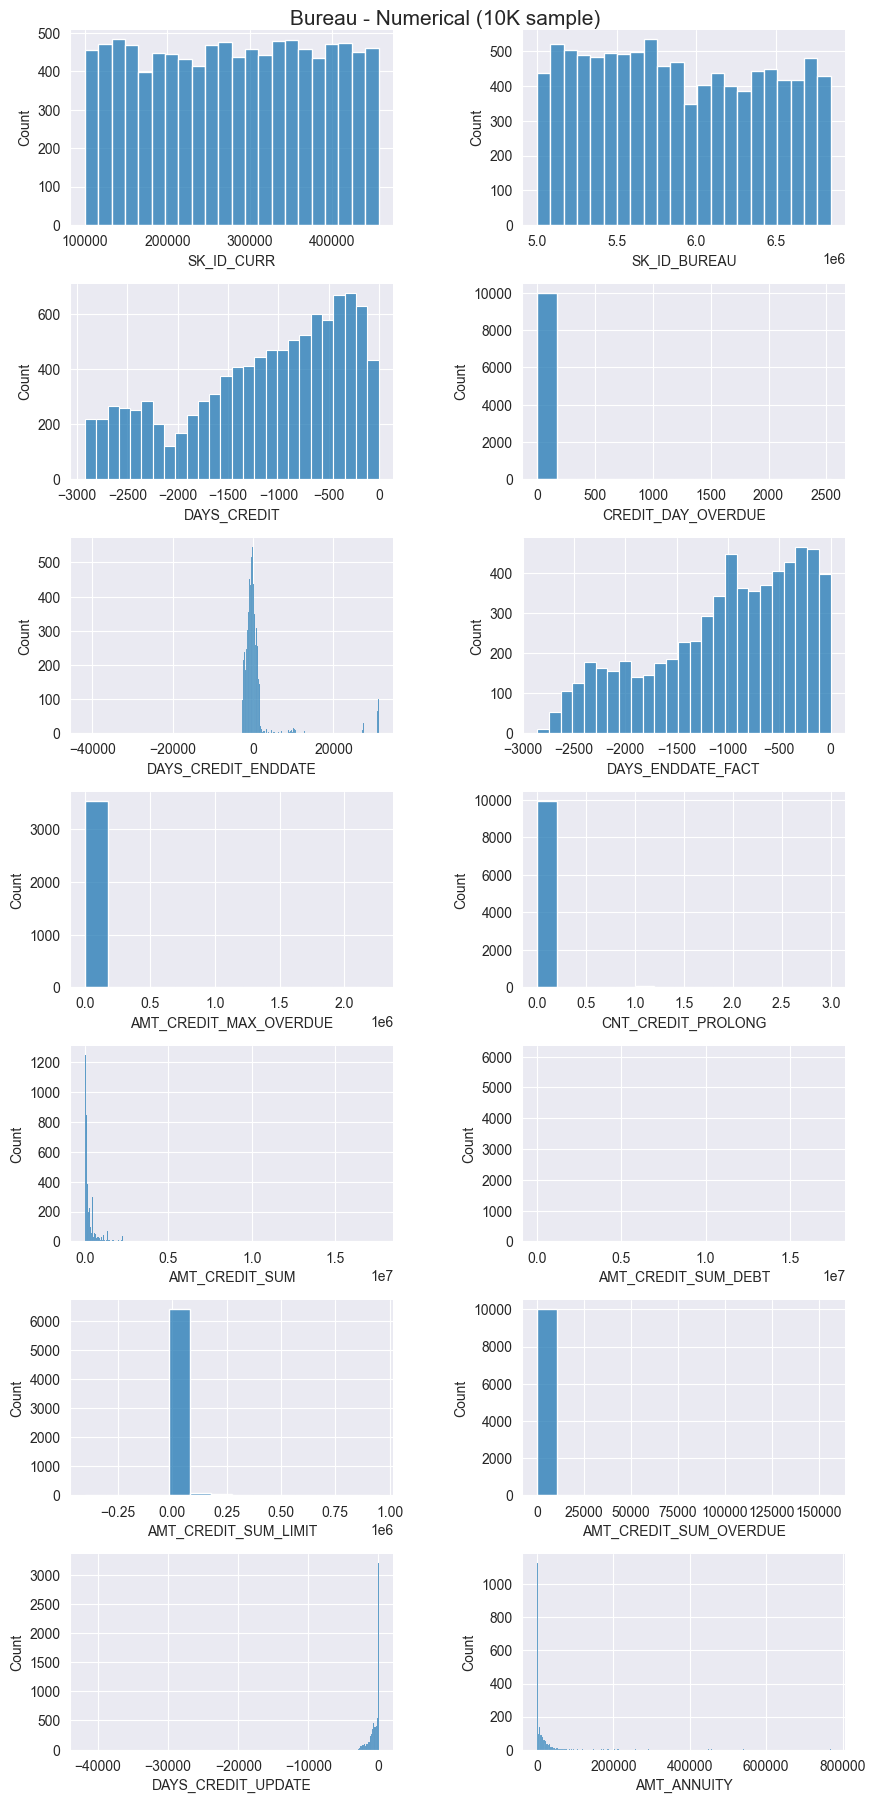

In [28]:
sample_size = 10000
sample_df = train_splits['bureau_train'].sample(n=sample_size, random_state=42)

fig, axes = plt.subplots(nrows=int(len(data_numerical_columns)/2), ncols=2,
                         figsize=(10, 20))
fig.subplots_adjust(hspace=0.3, wspace=0.4, top=0.97)

axes_flatten = axes.flatten()

for i, col in enumerate(data_numerical_columns):
    sns.histplot(x=col, data=sample_df,
                 ax=axes_flatten[i])
    sns.despine(top=True, right=True, left=False, bottom=False)

for j in range(len(data_numerical_columns), len(axes_flatten)):
    axes_flatten[j].axis('off')

fig.suptitle('Bureau - Numerical (10K sample)', fontsize=15)
plt.show()

**Categorical Columns**

In [29]:
train_splits['bureau_train'][data_categorical_columns].describe()

,CREDIT_ACTIVE,CREDIT_CURRENCY,CREDIT_TYPE
count,1171299,1171299,1171299
unique,4,4,15
top,Closed,currency 1,Consumer credit
freq,733220,1170286,854877


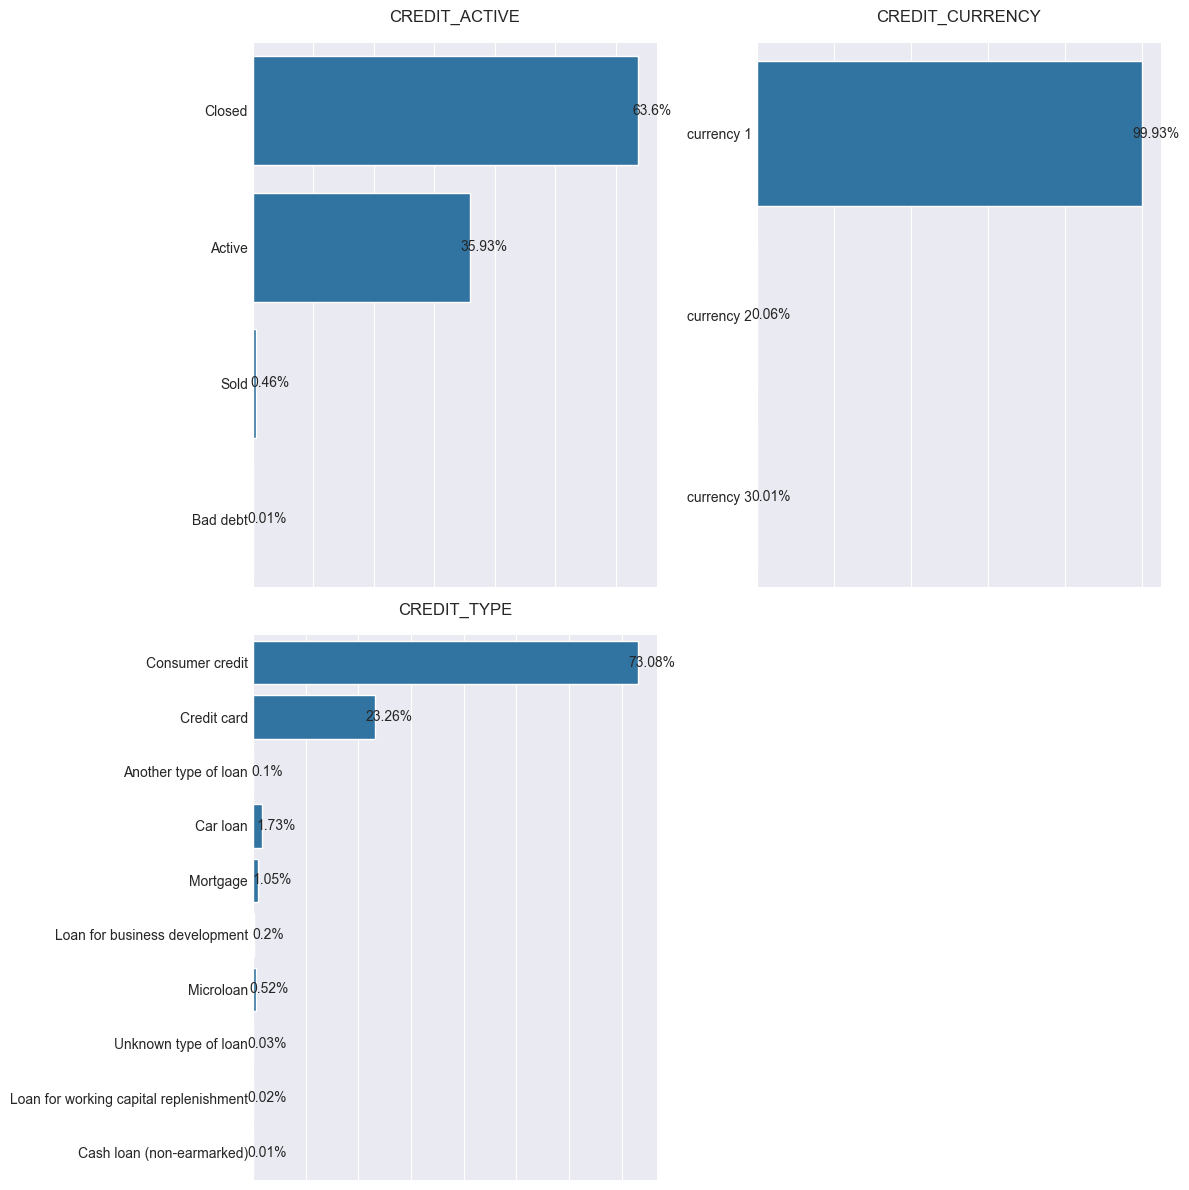

In [30]:
percentage_subplots(data=sample_df, columns=data_categorical_columns,
                    nrows=2, ncols=2)

**Previous Application Table**

In [31]:
data_categorical_columns = (categorical_columns_selector
                            (train_splits['previous_application_train']))
data_numerical_columns = numerical_columns_selector(train_splits['previous_application_train'])

sample_size = 10000
sample_df = train_splits['previous_application_train'].sample(n=sample_size, random_state=42)

binary_columns = [
    col for col in train_splits['previous_application_train'].columns
    if train_splits['previous_application_train'][col].nunique() == 2 and train_splits['previous_application_train'][col].dtype in ['int64', 'float64']
]

numerical_columns = [
    col for col in data_numerical_columns
    if col not in binary_columns
]

**Numerical without binary**

In [32]:
train_splits['previous_application_train'][numerical_columns].describe()

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION
count,1.131338e+06,1.131338e+06,885636.000000,1.131338e+06,1.131337e+06,5.318490e+05,8.757180e+05,1.131338e+06,531849.000000,3824.000000,3824.000000,1.131338e+06,1.131338e+06,885639.000000,682225.000000,682225.000000,682225.000000,682225.000000,682225.000000
mean,1.922760e+06,2.787847e+05,15825.163029,1.750320e+05,1.961304e+05,6.655917e+03,2.261608e+05,1.247765e+01,0.080233,0.189592,0.770321,-8.803045e+02,3.110308e+02,16.049511,342233.139564,13543.792372,33332.203226,76702.558754,82353.878603
std,5.326426e+05,1.028075e+05,14708.651245,2.931296e+05,3.189814e+05,2.098940e+04,3.153874e+05,3.333806e+00,0.107791,0.091978,0.100737,7.835238e+02,6.706590e+03,14.561707,88876.262475,71779.471935,106242.283210,149730.757829,153537.405045
min,1.000001e+06,1.000020e+05,0.000000,0.000000e+00,0.000000e+00,-9.000000e-01,0.000000e+00,0.000000e+00,-0.000014,0.034781,0.373150,-2.922000e+03,-1.000000e+00,0.000000,-2922.000000,-2892.000000,-2801.000000,-2889.000000,-2848.000000
25%,1.461768e+06,1.895830e+05,6255.810000,1.975500e+04,2.487600e+04,0.000000e+00,4.981500e+04,1.000000e+01,0.000000,0.160716,0.715645,-1.312000e+03,-1.000000e+00,6.000000,365243.000000,-1629.000000,-1244.000000,-1315.000000,-1268.000000
50%,1.922833e+06,2.794750e+05,11218.455000,7.086150e+04,8.055450e+04,1.795500e+03,1.101915e+05,1.200000e+01,0.062560,0.189136,0.835095,-5.830000e+02,4.000000e+00,12.000000,365243.000000,-825.000000,-357.000000,-535.000000,-495.000000
75%,2.383846e+06,3.678390e+05,20378.160000,1.800000e+05,2.156400e+05,7.704000e+03,2.295000e+05,1.500000e+01,0.108912,0.193330,0.852537,-2.710000e+02,8.500000e+01,24.000000,365243.000000,-408.000000,135.000000,-73.000000,-42.000000
max,2.845381e+06,4.562550e+05,418058.145000,5.850000e+06,4.509688e+06,3.060045e+06,5.850000e+06,2.300000e+01,1.000000,1.000000,1.000000,-1.000000e+00,4.000000e+06,84.000000,365243.000000,365243.000000,365243.000000,365243.000000,365243.000000


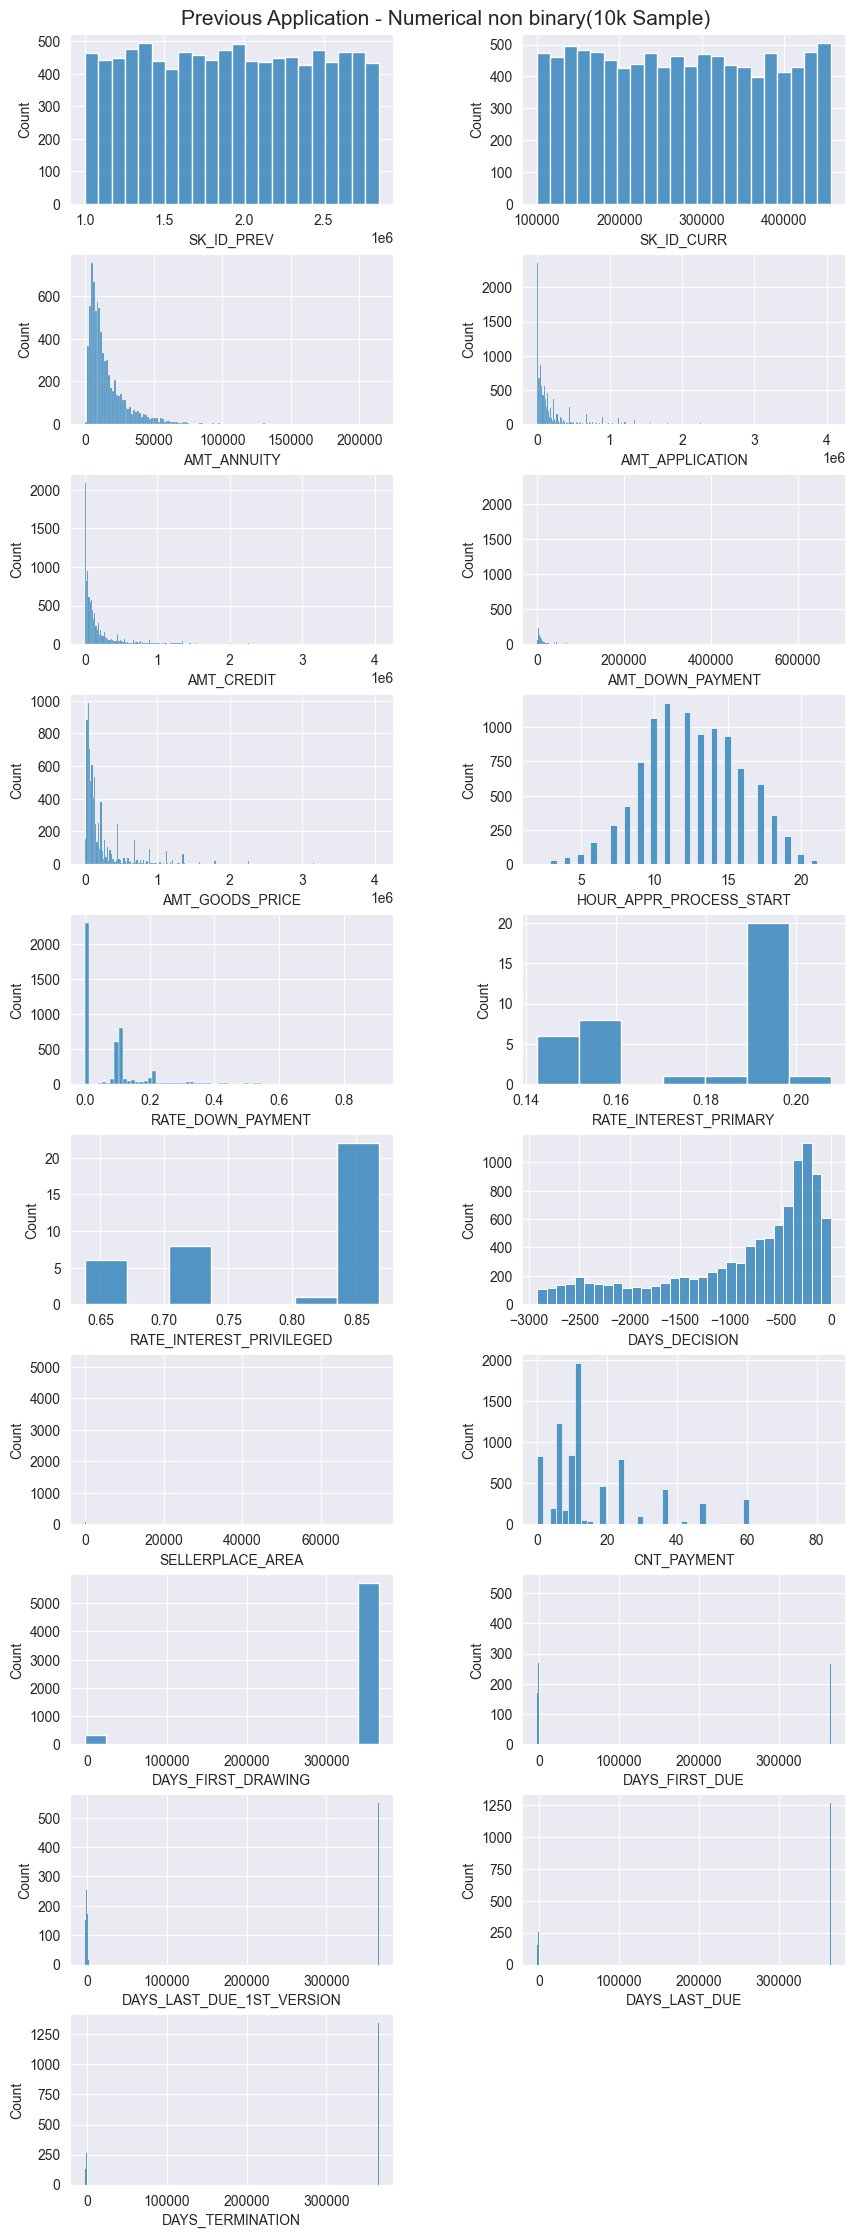

In [33]:
fig, axes = plt.subplots(nrows=10, ncols=2,
                         figsize=(10, 25))
fig.subplots_adjust(hspace=0.3, wspace=0.4, top=0.97)

axes_flatten = axes.flatten()

for i, col in enumerate(numerical_columns):
    sns.histplot(x=col, data=sample_df,
                 ax=axes_flatten[i])
    sns.despine(top=True, right=True, left=False, bottom=False)

for j in range(len(numerical_columns), len(axes_flatten)):
    axes_flatten[j].axis('off')

fig.suptitle('Previous Application - Numerical non binary(10k Sample)',
             fontsize=15)

plt.show()

**Binary - numerical**

In [34]:
train_splits['previous_application_train'][binary_columns].describe()

,NFLAG_LAST_APPL_IN_DAY,NFLAG_INSURED_ON_APPROVAL
count,1.131338e+06,682225.000000
mean,9.964644e-01,0.330047
std,5.935604e-02,0.470230
min,0.000000e+00,0.000000
25%,1.000000e+00,0.000000
50%,1.000000e+00,0.000000
75%,1.000000e+00,1.000000
max,1.000000e+00,1.000000


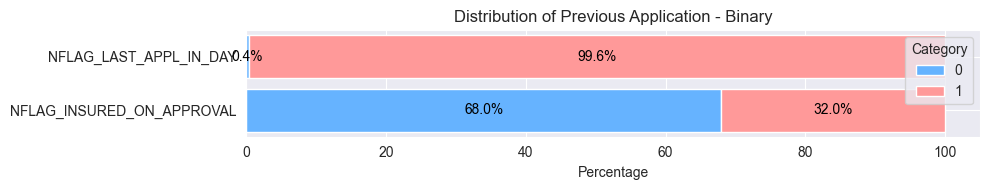

In [35]:
horizontal_binary_distribution(data=sample_df,
                               columns=binary_columns,
                               title='Distribution of Previous Application - '
                                     'Binary', figsize=(10, 2))

**Categorical**

In [36]:
train_splits['previous_application_train'][data_categorical_columns].describe()

,NAME_CONTRACT_TYPE,WEEKDAY_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,NAME_SELLER_INDUSTRY,NAME_YIELD_GROUP,PRODUCT_COMBINATION
count,1131338,1131338,1131338,1131338,1131338,1131338,1131338,575501,1131338,1131338,1131338,1131338,1131338,1131338,1131338,1131091
unique,4,7,2,25,4,4,9,7,4,27,5,3,8,11,5,17
top,Cash loans,WEDNESDAY,Y,XAP,Approved,Cash through the bank,XAP,Unaccompanied,Repeater,XNA,POS,XNA,Credit and cash offices,XNA,XNA,Cash
freq,501143,172240,1125558,630195,709043,706229,916439,342243,830701,637567,474630,720630,479768,571858,343334,188070


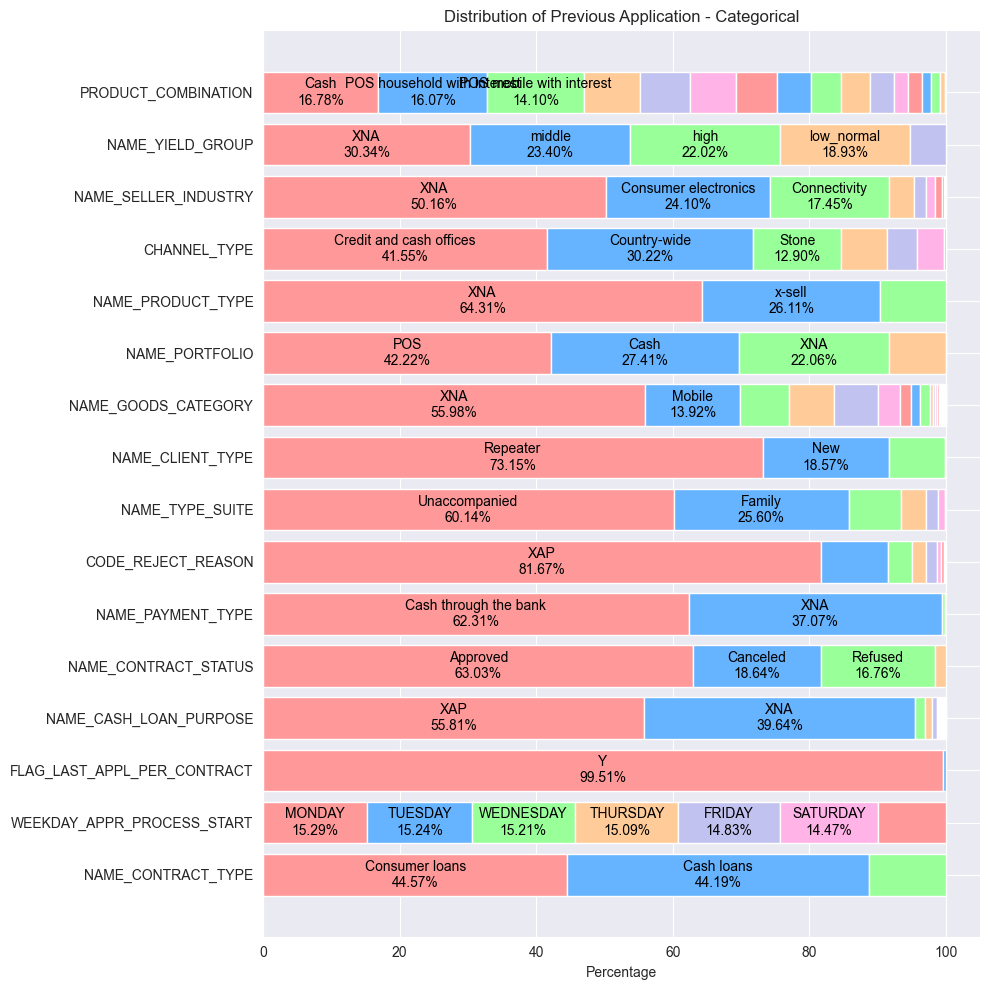

In [37]:
stacked_horizontal_feature_distribution(data=sample_df,
                                        columns=data_categorical_columns,
                                        title='Distribution of Previous Application - Categorical')

## 2.5. Aggregation
Objective: Aggregate data to the main table

Encode all 'object' columns because *mean*, *max*, etc, will be used as
aggregation functions. In our case, OneHotEncoder will be used to preserve 
the nominal quality of the features.

In [38]:
bureau_balance_encoded = encode_object_columns_with_ordinal(
    train_splits['bureau_balance_train']
)

credit_card_balance_encoded = encode_object_columns_with_ordinal(
    train_splits['credit_card_balance_train']
)

POS_CASH_balance_encoded = encode_object_columns_with_ordinal(
    train_splits['POS_CASH_balance_train']
)

previous_application_encoded = encode_object_columns_with_ordinal(
    train_splits['previous_application_train']
)


**Aggregate data to bureau and previous_application** using the following 
aggregation 
functions: 
['mean', 'sum', 'min', 'max', 'count'] <br>
All features merged to previous_application will include its original table 
name to avoid repeated feature names across several tables.

In [39]:
bureau_aggregator = BureauBalanceAggregator(agg_funcs=['mean', 'sum', 'min', 'max', 'count'])
bureau_transformed = bureau_aggregator.transform((train_splits['bureau_train'], 
                                                  bureau_balance_encoded))

previous_application_aggregator = PreviousApplicationAggregator(agg_funcs=['mean', 'sum', 'min', 'max', 'count'])
previous_application_transformed = previous_application_aggregator.transform(
    (previous_application_encoded, credit_card_balance_encoded, 
     train_splits['installments_payments_train'], POS_CASH_balance_encoded)
)

In [40]:
previous_application_transformed.head()

,SK_ID_PREV,SK_ID_CURR,previous_application_NAME_CONTRACT_TYPE,previous_application_AMT_ANNUITY,previous_application_AMT_APPLICATION,previous_application_AMT_CREDIT,previous_application_AMT_DOWN_PAYMENT,previous_application_AMT_GOODS_PRICE,previous_application_WEEKDAY_APPR_PROCESS_START,previous_application_HOUR_APPR_PROCESS_START,...,pos_cash_SK_DPD_mean,pos_cash_SK_DPD_sum,pos_cash_SK_DPD_min,pos_cash_SK_DPD_max,pos_cash_SK_DPD_count,pos_cash_SK_DPD_DEF_mean,pos_cash_SK_DPD_DEF_sum,pos_cash_SK_DPD_DEF_min,pos_cash_SK_DPD_DEF_max,pos_cash_SK_DPD_DEF_count
0,2030495,271877,1.0,1730.430,17145.0,17145.0,0.0,17145.0,2.0,15,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0
1,2802425,108129,0.0,25188.615,607500.0,679671.0,NaN,607500.0,4.0,11,...,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,5.0
2,2523466,122040,0.0,15060.735,112500.0,136444.5,NaN,112500.0,5.0,11,...,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,10.0
3,2819243,176158,0.0,47041.335,450000.0,470790.0,NaN,450000.0,1.0,7,...,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,12.0
4,1784265,202054,0.0,31924.395,337500.0,404055.0,NaN,337500.0,4.0,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
output_folder = os.path.join(project_root, "aggregated_data")
os.makedirs(output_folder, exist_ok=True)

# Save bureau_transformed as a .pkl file
bureau_file_path = os.path.join(output_folder, "bureau_transformed.pkl")
with open(bureau_file_path, "wb") as bureau_file:
    pickle.dump(bureau_transformed, bureau_file)

# Save previous_application_transformed as a .pkl file
previous_application_file_path = os.path.join(output_folder, "previous_application_transformed.pkl")
with open(previous_application_file_path, "wb") as previous_application_file:
    pickle.dump(previous_application_transformed, previous_application_file)

**Aggregate bureau and previous_application to the main table - <br>**
The final main table should include :

1. All columns from data_train.
2. Aggregated features from bureau_transformed and 
previous_application_transformed by SK_ID_CURR with mean, sum, max, min, count.
3. SK_ID_BUREAU_count and SK_ID_PREV_count as additional columns.

*During aggregation, object type columns will be encoded by OrdinalEncoder
from sklearn as OneHotEncoding was too resource intensive. However, in
the ideal scenario, OneHotEncoding should be used.*

In [42]:
from utils.get_data_merged_train import *
data_merged_train = get_data_merged_train(bureau_transformed,
                                          previous_application_transformed, 
                                          train_splits)
data_merged_train.head()


[2024-12-18 14:48:37.585401] === Starting data merge train process ===
[2024-12-18 14:48:37.585433] Processing bureau data...

[2024-12-18 14:48:37.585446] === Starting bureau processing ===
[2024-12-18 14:48:37.585450] Initial bureau shape: (1171299, 27)
[2024-12-18 14:48:37.585457] Encoding object columns in bureau data...
[2024-12-18 14:48:37.585466] Starting ordinal encoding...
[2024-12-18 14:48:37.683577] Found 3 object columns to encode
[2024-12-18 14:48:37.683609] Processing object columns...
[2024-12-18 14:48:37.728750] Initializing OrdinalEncoder...
[2024-12-18 14:48:37.728795] Performing encoding transformation...
[2024-12-18 14:48:37.978892] Creating DataFrame with encoded values...
[2024-12-18 14:48:37.979077] Concatenating encoded and non-encoded columns...
[2024-12-18 14:48:38.011440] Ordinal encoding completed successfully
[2024-12-18 14:48:38.021153] Bureau encoding completed
[2024-12-18 14:48:38.021162] Calculating bureau counts...
[2024-12-18 14:48:38.056603] Bureau 

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,pos_cash_SK_DPD_DEF_max_sum,pos_cash_SK_DPD_DEF_max_min,pos_cash_SK_DPD_DEF_max_max,pos_cash_SK_DPD_DEF_max_count,pos_cash_SK_DPD_DEF_count_mean,pos_cash_SK_DPD_DEF_count_sum,pos_cash_SK_DPD_DEF_count_min,pos_cash_SK_DPD_DEF_count_max,pos_cash_SK_DPD_DEF_count_count,SK_ID_PREV_count
0,310536,0,Cash loans,F,N,N,2,90000.0,227520.0,13189.5,...,0.0,0.0,0.0,4.0,8.50,34.0,7.0,13.0,4.0,5.0
1,365516,0,Cash loans,M,Y,Y,0,90000.0,161730.0,13095.0,...,0.0,0.0,0.0,4.0,7.75,31.0,5.0,12.0,4.0,6.0
2,242055,1,Cash loans,M,N,Y,0,135000.0,728847.0,26307.0,...,0.0,0.0,0.0,1.0,5.00,5.0,5.0,5.0,1.0,1.0
3,454894,1,Cash loans,M,N,N,0,135000.0,474183.0,34636.5,...,0.0,0.0,0.0,5.0,16.80,84.0,5.0,49.0,5.0,8.0
4,448321,0,Cash loans,F,N,Y,0,180000.0,254700.0,27558.0,...,0.0,0.0,0.0,1.0,12.00,12.0,12.0,12.0,1.0,2.0


In [43]:
output_folder = os.path.join(project_root, "aggregated_data")
os.makedirs(output_folder, exist_ok=True)

data_file_path = os.path.join(output_folder, "data_merged.pkl")
with open(data_file_path, "wb") as data_file:
    pickle.dump(data_merged_train, data_file)

# Improvements

1. Instead of aggregating data from other tables to the main table, maybe 
the model would benefit from predicting the probability of defaulting current 
loan based on previous bureau/loan data, which can then be aggregated to the
 main table.
2. Use cross validation and more carefully looking through the values to
determine which type of encoding is the best for our data.
3. Use individual aggregating functions best suited for each column,
creating more 'useful' features while aggregating.

changes made to tables:<br>
1. encode 'STATUS' and 'NAME_CONTRACT_STATUS' for **previous_application**, 
**credit_card_balance**, **POS_CASH_balance**, **bureau_balance**. one 
hot encoding for both
2. aggregate previous_application_encoded, credit_card_balance_encoded, 
POS_CASH_balance_encoded, installments_payments_train to bureau_train and 
previous_application_encoded
3. create SK ID count columns, drop SK_ID_BUREAU and SK_ID_PREV, merge 
tables to **data_train**

TODO:<br>
1. is data_train_test_split folder necessary? 

tables after kaggle or not kaggle: <br>
1. table_name_train (not kaggle)
2. table_name_test (for kaggle)
3. or data_kaggle folder has all kaggle files

tables after train test split:<br>
1. train_splits = {'data_train': data_train....}
2. test_splits = {'data_test': data_test....}
3. or train_test_split folder has them 

tables after encoding:<br>
1. previous_application_encoded
2. credit_card_balance_encoded
3. POS_CASH_balance_encoded
4. bureau_balance_encoded
5. train_splits['bureau_train']
6. train_splits['installments_payments_train']
7. train_splits['data_train']<br>

tables after aggregating to bureau and previous_application:<br>
1. bureau_transformed
2. previous_application_transformed<br>
3. train_splits['data_train'] <br>

table after merging to main table: <br>
1. data_merged_train

raw train/test files for modeling: 
1. in data_train_test_split folder *or*
2. dictionaries -> train_splits, test_splits
